In [1]:
import os
import numpy
import h5py
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendypy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
from scipy.optimize import curve_fit
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%aimport hom2m
%autoreload 1

# M2M with one-dimensional self-gravity with an external potential taking into account number/mass density ratio, $X_{nm}$, using the observational constraints of density and $<v^2>$

# Appying to Gaia DR2 from Bennett & Bovy (2019)

Here we investigate M2M with one-dimensional self-gravity and a constant density background, taking into account number/mass density ratio, which is defined with Xnm. We will apply it to the Gaia DR2 data from Bennett & Bovy (2019) which is created on ../BB19_GaiaDR2/py. 

## M2M model

First we use a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk) with a constant background for a model vertical disk structure. We will apply WendyM2M to the model disk with the constraints from the Gaia DR2 data.  

A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(z)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(z,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(z)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(z) = \rho_0\,e^{-\Phi(z)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = 4\pi G \rho(z) = 4\pi G \rho_0\,e^{-\Phi(z)/\sigma^2}\,,$

which has the solution

$\Phi(z) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{z}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, because

$\frac{\mathrm{d}\Phi(z)}{\mathrm{d}z} = \frac{2 \sigma^2}{2 H} \frac{\mathrm{sinh}\left[\frac{z}{2 H}\right]}{\mathrm{cosh}\left[\frac{z}{2 H}\right]} = \frac{2 \sigma^2}{2 H}  \mathrm{tanh}\left[\frac{z}{2 H}\right]$, $\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = \frac{2 \sigma^2}{4 H^2} \mathrm{sech}^2\left[\frac{z}{2 H}\right]$

Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(z) = \rho_0\,\mathrm{sech}^2\left(\frac{z}{2H}\right)\,$

and
 
$\Sigma = \int^{\infty}_{-\infty} \rho_0 \mathrm{sech}^2\left[\frac{z}{2 H}\right] dz = 4 H \rho_0$.


For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 z^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We consider that the observed density is number density of stars, but in M2M model, each element's $w$ traces mass. Here, we assume the number and mass denity ratio of $X_{nm}$, and fit it as well.

Read ../BB19_GaiaDR2/py/gdr2_bb18_*.h for the target data. 

In [3]:
# read the vertical number density data
# colour ID in BB19_GaiaDR2
cid = 0
file_posinput='../BB19_GaiaDR2/py/gdr2_bb18_pos_colid'+str(cid)+'.h5'
with h5py.File(file_posinput, 'r') as f:
    print(f.keys())
    z_pmock = f['z'].value
print(' Number of stars for vertical number density =',len(z_pmock))
  
# read all the vertical veloity data
# file_velinput='../BB19_GaiaDR2/py/gdr2_bb18_vz.h5'
#
# read the vertical velocity data for the selected colour ID
file_velinput='../BB19_GaiaDR2/py/gdr2_bb18_posvz_colid'+str(cid)+'.h5'
with h5py.File(file_velinput, 'r') as f:
    print(f.keys())
    z_vmock = f['z'].value
    vz_vmock = f['vz'].value
print(' Number of stars for vertical velocity =',len(z_vmock))



KeysView(<HDF5 file "gdr2_bb18_pos_colid0.h5" (mode r)>)
 Number of stars for vertical number density = 154629
KeysView(<HDF5 file "gdr2_bb18_posvz_colid0.h5" (mode r)>)
 Number of stars for vertical velocity = 105882


# Set solar vertical position and velocity.

In [4]:
# tempolary set xnm_true = 1/250(pc) to make it pc^-3 unit
xnm_true = 1.0/(250.0**2)
# vertical positon of the Sun from BB19
zsun_true = 0.0208
# vertical solar velocity
vzsun_true =  7.25
# adjust the vertical positons and velocities.
z_pmock = z_pmock+zsun_true
z_vmock = z_vmock+zsun_true
vz_vmock = vz_vmock+vzsun_true
# set mass =1
m_pmock = numpy.ones_like(z_pmock)
m_vmock = numpy.ones_like(z_vmock)

Unit normalisation: 2 pi G= 1 (2 pi x 6.67408$\times 10^{-8}$ cm$^{3}$ g$^{-1}$ s$^{-2}$), L=1 kpc (3.0857$\times 10^{18}$ cm), V=1 km/s (1.0e5 cm/s)

In [5]:
# units
twopigunit_cgs = (2.0*numpy.pi)*6.67408e-8
msun_cgs = 1.98847e33 # 1 Msun
# munit_cgs = 1.98847e33  # 1 Msun
lunit_kpc = 1.0
vunit_kms = 1.0
lunit_pc = lunit_kpc*1000.0
lunit_cgs = lunit_kpc*3.0857e21 # 1 kpc
vunit_cgs = vunit_kms*1.0e5 # 1 km/s
# time unit
tunit_cgs = lunit_cgs/vunit_cgs
print(' time unit (s) =', tunit_cgs)
yr_s = ((365.0*24.0*3600.0)*3+(366.0*24.0*3600.0))/4.0
print(' 1 year (s)=', yr_s)
print(' time unit (Myr) = ',tunit_cgs/yr_s/1.0e6)
# mass unit 
munit_cgs = lunit_cgs**3/(twopigunit_cgs*(tunit_cgs**2))
munit_msun = munit_cgs/msun_cgs
print(' mass unit (Msun) =', munit_msun)
# velocity unit (when mass is unit)
# vunit_kms = lunit_cgs/tunit_cgs/1.0e5
# print (' velocity unit (km/s) =', vunit_kms)
# normalise position and velocity

 time unit (s) = 3.0857e+16
 1 year (s)= 31557600.0
 time unit (Myr) =  977.7993256774913
 mass unit (Msun) = 37005.25326467715


In [6]:
z_pmock = z_pmock/lunit_kpc
z_vmock = z_vmock/lunit_kpc
vz_vmock = vz_vmock/vunit_kms

Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



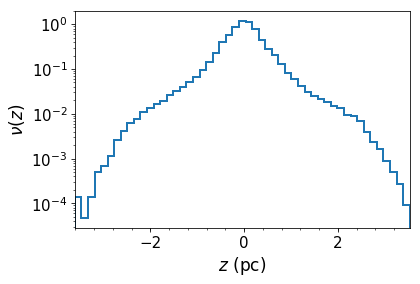

In [7]:
figsize(6,4)
_= bovy_plot.bovy_hist(z_pmock,bins=51,normed=True,
                       xlabel=r'$z$ (pc)',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution. Note that the position data are complete between 0.0163 and 1.0833 kpc, according to BB19.

In [8]:
# We only observe the density at a few z
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9,
#                     -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
h_obs= 0.05
z_obs= numpy.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                    0.55, 0.6, 0.7,
                    -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45,
                    -0.5, -0.55, -0.6, -0.65, -0.7])

# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
#                     1.1, 1.2, 1.3, 1.4, 1.5, 
#                    -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0,
#                    -1.1, -1.2, -1.3, -1.4, -1.5])
#h_obs = 0.1
dens_obs= xnm_true*hom2m.compute_dens(z_pmock,zsun_true,z_obs,h_obs,w=m_pmock)
ns_obs= hom2m.compute_nstar(z_pmock,zsun_true,z_obs,h_obs,w=m_pmock)
#dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
#     /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs_noise= dens_obs/numpy.sqrt(ns_obs)
print(' dens uncertainties=', dens_obs_noise)
# numpy.random.seed(203)
# noise is already included in the data
# dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

 dens uncertainties= [0.02963843 0.02780509 0.02576507 0.02378534 0.02176181 0.01929078
 0.01743815 0.01597534 0.01493941 0.01415122 0.01335822 0.01150838
 0.03004625 0.0282709  0.02595533 0.02387062 0.02259736 0.02120078
 0.02017103 0.01882043 0.01712209 0.01571287 0.01394686 0.01231964
 0.01131526]


The observed density is:

<ErrorbarContainer object of 3 artists>

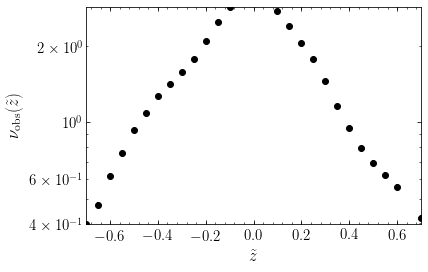

In [11]:
zmin = -1.1
zmax = 1.1
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$')
zs = numpy.linspace(zmin, zmax, 101)
# plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
#            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [12]:
# We only observe the v2 at a few z (same as before)
v2_obs, nv2_obs, madv2_obs= hom2m.compute_medv2(z_vmock,vz_vmock,zsun_true,z_obs,h_obs)
# recomputer v^2
v2_obs= hom2m.compute_v2(z_vmock,vz_vmock,zsun_true,z_obs,h_obs)
print('N star in each z bin for vz=',nv2_obs)
# standard deviation from MAD, which is too big?
kmad = 1.4826
# std of mean
#v2_obs_noise=kmad*madv2_obs/numpy.sqrt(nv2_obs)
print('vz2=', v2_obs)
# print('MAD vz2=', madv2_obs)
# use Poisson noise
v2_obs_noise= v2_obs/numpy.sqrt(nv2_obs)
print('vz2 noise=', v2_obs_noise)

# numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
# data already have the noise
# v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

N star in each z bin for vz= [8098. 7152. 6082. 5241. 4057. 3009. 2122. 1412.  956.  542.  320.   70.
 8510. 7305. 6136. 5184. 4470. 3874. 3152. 2202. 1506.  806.  439.  194.
   85.]
vz2= [362.11911228 401.94616127 426.27349007 487.79357598 524.18185006
 572.60342638 635.70336579 678.48672119 621.93458671 670.17682281
 661.74547025 448.91478226 370.77297621 405.8842091  448.01858701
 487.34247    496.16270674 501.50979144 485.83437847 498.178484
 525.43427241 533.57421624 562.55707065 609.80056192 628.93865803]
vz2 noise= [ 4.02404252  4.75285027  5.46594323  6.73796882  8.22961419 10.43861424
 13.8000869  18.05610219 20.11480205 28.78655942 36.99269638 53.65557909
  4.01923401  4.74888929  5.719438    6.76864542  7.42113542  8.05748691
  8.65356656 10.61637644 13.5396024  18.79435017 26.84938408 43.78112886
 68.21797551]


<ErrorbarContainer object of 3 artists>

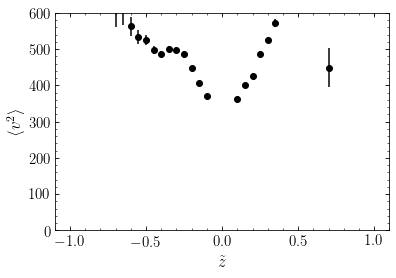

In [13]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmin, zmax],yrange=[0.0,600.0],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean velocity:

In [14]:
# We only observe the v2 at a few z (same as before)
v_obs, nv_obs, madv_obs = hom2m.compute_medv(z_vmock,vz_vmock,zsun_true,z_obs,h_obs)
# use constant noise
v_obs_noise= kmad*madv_obs/numpy.sqrt(nv_obs)
print(' vz =', v_obs)

 vz = [-0.01378562 -0.50755312 -0.18400474 -0.54316544 -0.41838085 -0.91331742
 -0.54974546 -2.8864085  -1.30593077  0.11355969 -1.9043583  -0.60800894
 -0.03085334 -0.31325761 -0.05326631  0.26431186 -0.39016714 -0.3578143
 -1.19514566 -1.06613835 -2.89774337 -3.25065401 -1.75284116 -0.77310286
 -5.8196382 ]


### Re-define $v^2$ using MAD of $v$

In [15]:
v2_obs=(kmad*madv_obs)**2
v2_obs_noise = v2_obs/numpy.sqrt(nv_obs)
print(' new v2=', v2_obs)
print(' new v2 noise=',v2_obs_noise)

 new v2= [217.63041157 225.05609934 255.13812072 275.8111712  317.11547056
 408.94064702 462.80386376 604.90781734 562.25582269 504.90895961
 488.94195909 418.49629739 218.16498006 267.10780726 314.02416336
 378.66919762 392.8324774  375.1158072  365.80568002 334.0667631
 314.22301865 324.83624682 283.70908398 316.49180816 435.33886925]
 new v2 noise= [ 2.41841427  2.66119706  3.27153932  3.80982277  4.97868817  7.4550264
 10.04671971 16.09799724 18.18465289 21.68769685 27.33268644 50.01987475
  2.36494072  3.12519033  4.0088554   5.25929441  5.87561897  6.02678304
  6.51564389  7.1190921   8.09702557 11.44186879 13.5406958  22.72278758
 47.21913011]


<ErrorbarContainer object of 3 artists>

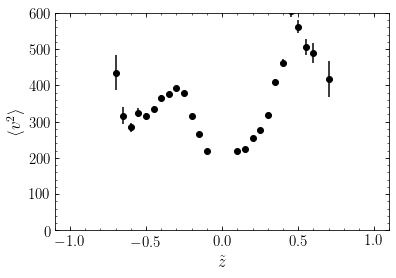

In [16]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmin, zmax],yrange=[0.0,600.0],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

<ErrorbarContainer object of 3 artists>

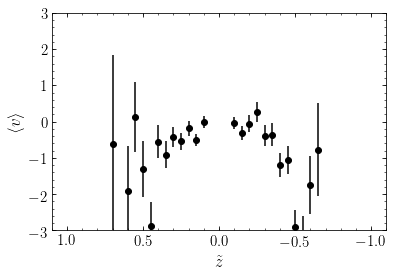

In [17]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v\rangle$',
                   xrange=[zmax, zmin],yrange=[-3.0,3.0],gcf=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color='k')

Now we fit the density profile with $\mathrm{sech}^2$ profile.

fit parameter a, b, c= [2.79377236 0.19589296 0.01633139]


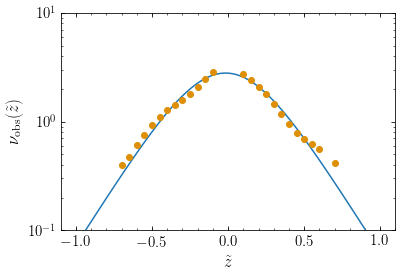

In [18]:
# define sech2 profile
def func_sech2(x, a, b, c):
    return a/(numpy.cosh((x+c)/(2.0*b))**2)
# fit the density with a sech2 profile
popt, pconv = curve_fit(func_sech2, z_obs, dens_obs, bounds=(0, 20.0))
print('fit parameter a, b, c=', popt)
z_out= numpy.linspace(zmin, zmax, 101)
dens_fit= func_sech2(z_out, *popt)
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_out, dens_fit,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.1,10.0],gcf=True)
bovy_plot.bovy_plot(z_obs, dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
yscale('log',nonposy='clip')

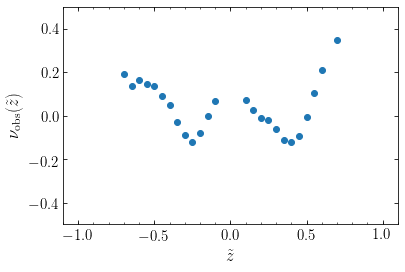

In [19]:
# plot the density differences
dens_fit_obs = func_sech2(z_obs, *popt)
dens_diff = (dens_obs-dens_fit_obs)/dens_obs
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_obs, dens_diff,'o', color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5, 0.5],gcf=True)
yscale('linear',nonposy='clip')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [20]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
v_data= {'type':'v','pops':0,'zobs':z_obs,'obs':v_obs,'unc':v_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]
print('zobs=',data_dicts['type'=='dens']['zobs'])

zobs= [ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.7
 -0.1  -0.15 -0.2  -0.25 -0.3  -0.35 -0.4  -0.45 -0.5  -0.55 -0.6  -0.65
 -0.7 ]


## M2M Fitting both $\omega$ and $X_{nm}$

 initial mass density (Msun/pc^2) = 55.50787989701573
 initial zh (kpc), tdyn (Myr)= 0.26666666666666666 0.420768


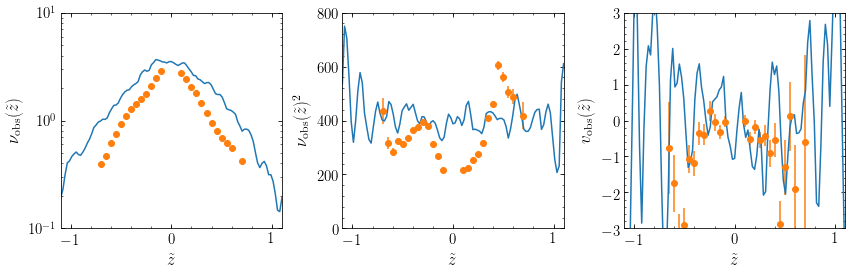

In [24]:
n_m2m= 4000
sigma_init= 20.0
h_m2m= 0.05
# set a guess
xnm_m2m = 0.0025
# total surface_mass density  Munit/Lunit(kpc)^2 
totmass_init = 1500.0 
print(' initial mass density (Msun/pc^2) =', totmass_init*munit_msun/1.0e6)
zh_init = sigma_init**2./totmass_init  # Where 2\pi G= 1 so units of zh are ~311 pc
tdyn = zh_init/sigma_init
print(' initial zh (kpc), tdyn (Myr)=', zh_init, tdyn*yr_s/1.0e6)
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_init,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
# v2_init, nv2_init, madv2_init= hom2m.compute_medv2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
# for plot
densmin = 0.1
densmax = 10.0
v2min = 0.0
v2max = 800.0
vmin = -3.0
vmax = 3.0
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})^2$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin, vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()


In [25]:
# set initial omega
# dark matter density (Msun pc^-3)
# conventional value
# rhodm_msunpc3= 0.01
rhodm_msunpc3= 0.03
densunit_msunpc3 = munit_msun/(lunit_pc**3)
# omega = sqrt(4 pi G rho_dm), 2 pi G=1, 
omega_m2m = numpy.sqrt(2.0*rhodm_msunpc3/densunit_msunpc3)
print(' initial DM density (Msun pc^-3) =', rhodm_msunpc3)
print(' omega(initial)=', omega_m2m)

 initial DM density (Msun pc^-3) = 0.03
 omega(initial)= 40.26650489257022


In [26]:
# step size for particle integration
step= 0.05*tdyn
nstep= 10000
#eps= 10.**-3.5
# eps = [10.0**-5.0, 10.0**-5.0, 10.0**-7.0]
# eps weight, omega, xnm
# eps = [10.0**-7.0, 10.0**-8.0, 10.0**-8.0]
eps = [10.0**-1.0, 10.0**-0.0, 10.0**-8.0]
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.05
zsun_m2m= zsun_true
fit_omega = True
skipomega= 10
skipxnm = 100
fit_xnm = True
prior= 'entropy'
use_v2=True
w_out,omega_out,xnm_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     fit_omega=fit_omega,skipomega=skipomega,
                     number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm, skipxnm=skipxnm)
w_out= w_out[:,0]

 mass surface density (Msun/pc^2) = 56.676930771943496
 omega fit =  0.6990189659466742
 DM density (Msun/pc^-3) = 9.040892467765185e-06
 Xnm fit=  0.0015125151678438435
Velocity dispersions: 16.93133662153628
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)



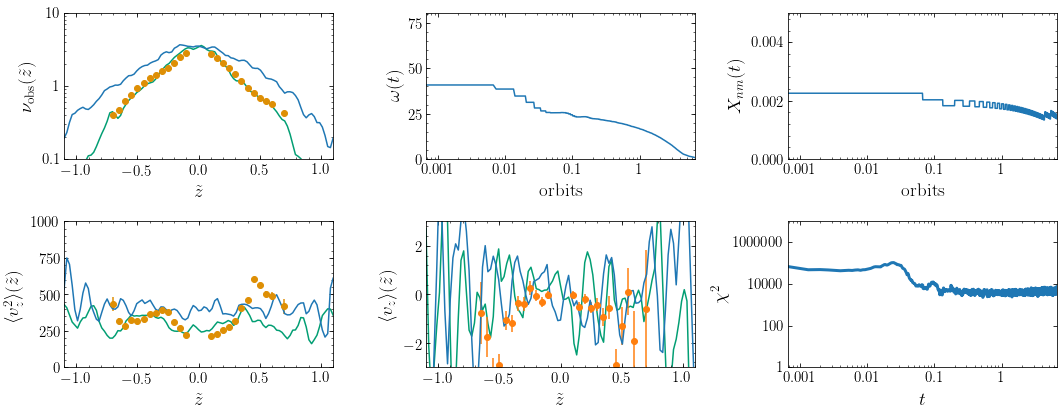

In [27]:
# print(' total mass =', numpy.sum(w_out))
print(' mass surface density (Msun/pc^2) =', numpy.sum(w_out)*munit_msun/1.0e6)
print(' omega fit = ',omega_out[-1])
print(' DM density (Msun/pc^-3) =', (omega_out[-1]**2/2.0)*densunit_msunpc3)
print(' Xnm fit= ', xnm_out[-1])
print("Velocity dispersions:",\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
z_out= numpy.linspace(zmin, zmax, 101)
v2max = 1000.0
#
dens_final= xnm_out[-1]*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin,densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
# zs = numpy.linspace(zmin, zmax, 101)
# plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
#            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min,v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
# omega evolution
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,omega_m2m*2.0],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
# axhline(omegadm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(
    FuncFormatter(
        lambda y,pos: 
        (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,5)
# _= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
# xs= numpy.linspace(zmin, zmax, 201)
# plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
#     lw=2.,zorder=2,color=constraint_color)
# _= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
# xlim(zmin, zmax)
# ylim(0.,2.)
# xlabel(r'$v_z$')
# ylabel(r'$p(v_z)$')
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z\rangle(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
# print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
#      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,xnm_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,xnm_m2m*2.0],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$X_{nm}(t)$',gcf=True)
# axhline(xnm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [ ]:
# savefilename= 'xnmomega_rhov2obs_data.sav' 
savefilename='xnmomega_rhov2obs_colid'+str(cid)+'.sav'
# if os.path.exists(savefilename):
#    with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#    w_out,z_m2m,vz_m2m,omega_m2m,xnm_m2m,zsun_m2m,data_dicts,w_init= out
# else:
save_pickles(savefilename,w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,
             zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
             w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
             dens_init,v2_init,v_init,\
             nstep,step,tdyn,eps,Q,wevol,windx)